# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
!pip install torch --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install pandas
!pip install numpy
!pip install tqdm
!pip install matplotlib
!pip install ipywidgets

In [ ]:
!pip install scikit-learn

In [131]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print(torch.version.cuda)

cuda
11.8


In [132]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [133]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-20 17:26:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [          <=>       ] 201.24M  21.7MB/s    in 11s     

2023-10-20 17:26:27 (19.1 MB/s) - ‘data.txt.zip’ saved [211011981]



In [134]:
df: pd.DataFrame = pd.read_csv("data.txt.zip", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [135]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
Y_train = y[:train_size]
X_test = X[train_size:, :]
Y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [136]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()

In [137]:
set_random_seed(42)

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# когда мы будем обучать сетку, нам надо будет сравнить предикты на трейне с Y_train
# но эти предикты будут делаться на основе отскейленных данных, поэтому и Y_train
# надо тоже отскейлить для правильного подсчета лосса
Y_train_scaled = y_scaler.fit_transform(Y_train.reshape(-1, 1))

In [138]:
# функция для инверсии трансформаций скейлера
def inverse_scaling(predictions, scaler):
    return scaler.inverse_transform(predictions.reshape(-1, 1))

In [139]:
set_random_seed(42)

# функция для инверсии трансформаций, примененных к торчовому тензору
def inverse_scaling_torch(predictions, scaler):
    with torch.no_grad():
        predictions_np = predictions.numpy()

    inverted_predictions = torch.tensor(
        scaler.inverse_transform(predictions_np.reshape(-1, 1)),
        dtype=torch.float32
    ).squeeze()

    return inverted_predictions

In [140]:
alphas = [0.1, 1, 10, 100, 200]

In [141]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

set_random_seed(42)

train_metrics = []
test_metrics = []

for alpha in tqdm(alphas):
    model: Ridge = Ridge(alpha).fit(X_train_scaled, Y_train_scaled)

    prediction_train = model.predict(X_train_scaled)
    prediction_test = model.predict(X_test_scaled)

    rmse_train = mean_squared_error(
        y_true=Y_train,
        y_pred=inverse_scaling(prediction_train, y_scaler),
        squared=False
    )

    rmse_test = mean_squared_error(
        y_true=Y_test,
        y_pred=inverse_scaling(prediction_test, y_scaler),
        squared=False
    )

    train_metrics.append(rmse_train)
    test_metrics.append(rmse_test)

  0%|          | 0/5 [00:00<?, ?it/s]

In [142]:
set_random_seed(42)

print('RMSE on train:')
print(*train_metrics, sep='\n')

print('\nRMSE on test:')
print(*test_metrics, sep='\n')

print(f'\nMean RMSE {np.mean(test_metrics)}')

RMSE on train:
9.5528229679047
9.552822967970322
9.552822974530542
9.552823628653094
9.552825602505337

RMSE on test:
9.510160718781293
9.510160820470436
9.510161842816515
9.510172609963115
9.510185725331453

Mean RMSE 9.510168343472563


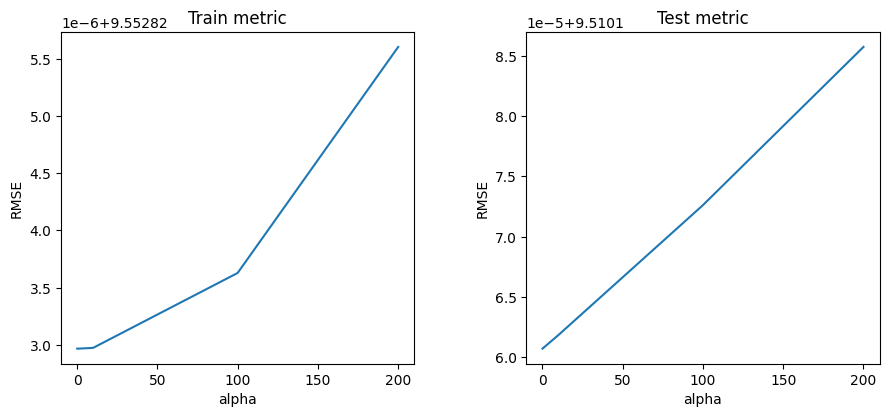

In [143]:
set_random_seed(42)

figure, (ax1, ax2) = plt.subplots(1, 2)
figure.set_size_inches(10, 5)
figure.tight_layout(pad=5)

ax1.plot(alphas, train_metrics)
ax1.set_title('Train metric')
ax1.set_xlabel('alpha')
ax1.set_ylabel('RMSE')

ax2.plot(alphas, test_metrics)
ax2.set_title('Test metric')
ax2.set_xlabel('alpha')
ax2.set_ylabel('RMSE');

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [144]:
set_random_seed(42)

best_rmse_metric = np.sqrt(
    np.mean(
        (Y_test - np.mean(Y_train)) ** 2
    )
)
best_rmse_metric

10.85246390513634

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [145]:
import warnings

set_random_seed(42)
warnings.filterwarnings("ignore")

In [146]:
# с дата лоадером у меня лосс улетает в бесконечность, и в весах модели лежат наны
# поэтому буду использовать только первые 20к объектов
batch_size = 20000

In [147]:
set_random_seed(42)

X_train_tensor = torch.tensor(
    X_train_scaled[:batch_size, :],
    dtype=torch.float32
)

# непосредственно для обучения
Y_train_tensor = torch.tensor(
    Y_train_scaled[:batch_size, 0],
    dtype=torch.float32
)

# для подсчета честного лосса на трейне
Y_train_tensor_not_scaled = torch.tensor(
    Y_train[:batch_size],
    dtype=torch.float32
)

# к сожалению, бесплатная гпу коллаба не вывозит предикт на всех объектах,
# поэтому для этого задания тоже беру только часть датасета
X_test_tensor = torch.tensor(
    X_test_scaled[:batch_size, :],
    dtype=torch.float32
)

Y_test_tensor = torch.tensor(
    Y_test[:batch_size],
    dtype=torch.float32
)

X_train_tensor.size(), Y_train_tensor.size(), X_test_tensor.size(), Y_test_tensor.size()

(torch.Size([20000, 90]),
 torch.Size([20000]),
 torch.Size([20000, 90]),
 torch.Size([20000]))

In [148]:
set_random_seed(42)

final_loss_train = []
final_metric_train = []

final_loss_test = []
final_metric_test = []

In [149]:
set_random_seed(42)

nn_model = nn.Sequential(
    nn.Linear(X_train_tensor.shape[1], 1)
)
nn_model.to(device)

Sequential(
  (0): Linear(in_features=90, out_features=1, bias=True)
)

In [150]:
set_random_seed(42)

# функция для шага градиентного спуска
def make_gradient_descent_step(params, learning_rate=0.01):
    with torch.no_grad():
        for param in params:
            param -= learning_rate * param.grad

In [151]:
set_random_seed(42)

for epoch in tqdm(range(10)):
    # делаем предикт
    train_prediction = nn_model(X_train_tensor.to(device))

    # считаем мсе лосс на трейне
    loss = torch.mean((train_prediction - Y_train_tensor.to(device)) ** 2)

    # считаем честный мсе лосс на трейне
    inverted_train_prediction = inverse_scaling_torch(
        train_prediction.cpu(),
        y_scaler
    )
    train_loss = torch.mean(
        (inverted_train_prediction.to(device) - Y_train_tensor_not_scaled.to(device)) ** 2
    )

    # считаем рмсе метрику на трейне
    train_metric = torch.sqrt(train_loss)

    final_loss_train.append(train_loss.item())
    final_metric_train.append(train_metric.item())

    # считаем градиенты
    loss.backward()

    # делаем шаг градиентного спуска
    make_gradient_descent_step(nn_model.parameters(), learning_rate=0.05)

    # подчищаем градиенты, чтобы они не суммировались в следующих эпохах
    nn_model.zero_grad()

    with torch.no_grad():
        # делаем предикт на тесте
        test_prediction = nn_model(X_test_tensor.to(device))

        # считаем мсе лосс на тесте
        inverted_test_prediction = inverse_scaling_torch(
            test_prediction.cpu(),
            y_scaler
        )
        test_loss = torch.mean(
            (inverted_test_prediction.to(device) - Y_test_tensor.to(device)) ** 2
        )

        # считаем рмсе метрику на тесте
        test_metric = torch.sqrt(test_loss)

        final_loss_test.append(test_loss.item())
        final_metric_test.append(test_metric.item())

    print('===============')
    print(f'Epoch: {epoch + 1}')
    print(f'\ttrain ====>')
    print(f'\t\tloss: {train_loss}')
    print(f'\t\tmetric: {train_metric}\n')

    print(f'\ttest  ====>')
    print(f'\t\tloss: {test_loss}')
    print(f'\t\tmetric: {test_metric}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
	train ====>
		loss: 146.9086151123047
		metric: 12.120586395263672

	test  ====>
		loss: 150.35174560546875
		metric: 12.261799812316895
Epoch: 2
	train ====>
		loss: 138.0481719970703
		metric: 11.749390602111816

	test  ====>
		loss: 144.53749084472656
		metric: 12.022374153137207
Epoch: 3
	train ====>
		loss: 133.12289428710938
		metric: 11.53788948059082

	test  ====>
		loss: 140.34129333496094
		metric: 11.846572875976562
Epoch: 4
	train ====>
		loss: 129.60174560546875
		metric: 11.384276390075684

	test  ====>
		loss: 137.0586395263672
		metric: 11.707204818725586
Epoch: 5
	train ====>
		loss: 126.85366821289062
		metric: 11.262933731079102

	test  ====>
		loss: 134.44964599609375
		metric: 11.595242500305176
Epoch: 6
	train ====>
		loss: 124.65605926513672
		metric: 11.164947509765625

	test  ====>
		loss: 132.35369873046875
		metric: 11.504508018493652
Epoch: 7
	train ====>
		loss: 122.87625885009766
		metric: 11.084956169128418

	test  ====>
		loss: 130.656127929687

In [152]:
def draw_charts(train_loss, train_metrics, test_loss, test_metrics):

    figure, (ax1, ax2) = plt.subplots(1, 2)
    figure.set_size_inches(12, 6)
    figure.tight_layout(pad=5)

    ax1.plot(train_loss, label='Train')
    ax1.plot(test_loss, label='Test')
    ax1.set_title('MSE loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')

    ax2.plot(train_metrics)
    ax2.plot(test_metrics)
    ax2.set_title('RMSE metric')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('RMSE');

    figure.legend()

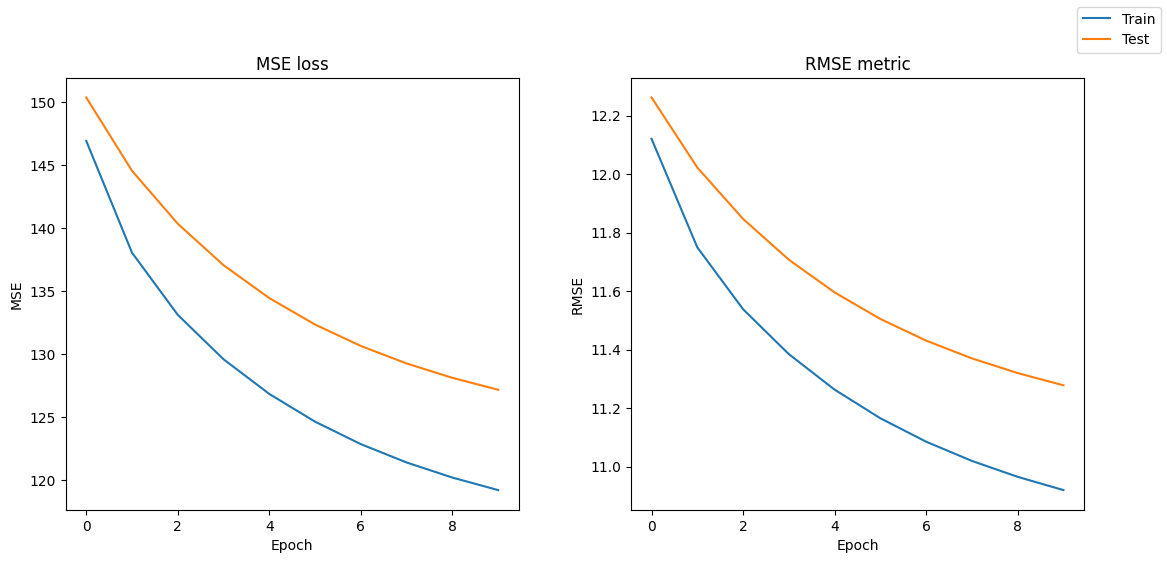

In [153]:
draw_charts(final_loss_train, final_metric_train, final_loss_test, final_metric_test)

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [154]:
import torch.optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [155]:
class CustomDataset(Dataset):

    def __init__(self, x: torch.Tensor, y: torch.Tensor):
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index, :], self.y[index]

In [156]:
class CustomNet(nn.Module):

    def __init__(self, input_features_size: int, dropout_p: float):
        super().__init__()

        self.fully_connected1 = nn.Sequential(
            nn.Linear(input_features_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
        )
        self.fully_connected2 = nn.Sequential(
            nn.Dropout(p=p),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
        )
        self.fully_connected3 = nn.Sequential(
            nn.Dropout(p=p),
            nn.Linear(256, 192),
            nn.BatchNorm1d(192),
            nn.LeakyReLU(),
        )
        self.fully_connected4 = nn.Sequential(
            nn.Dropout(p=p),
            nn.Linear(192, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.fully_connected5 = nn.Sequential(
            nn.Dropout(p=p),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.fully_connected6 = nn.Sequential(
            nn.Dropout(p=p),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.fully_connected1(x)
        out = self.fully_connected2(out)
        out = self.fully_connected3(out)
        out = self.fully_connected4(out)
        out = self.fully_connected5(out)
        out = self.fully_connected6(out)

        return out

In [157]:
def train(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: nn.modules.loss._Loss,
    train_dataloader: torch.utils.data.DataLoader,
    device: str
):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_dataloader - torch.utils.data.Dataloader with train dataset
        device - CPU or GPU
    """

    model.train()
    for x_train, y_train in tqdm(train_dataloader):
        prediction = model(x_train.to(device))

        # считаем лосс по критерию
        loss = criterion(prediction, y_train.to(device))

        # считаем градиенты
        loss.backward()

        # делаем шаг градиентного спуска и обнуляем посчитанные градиенты,
        # чтобы они не суммировались на следующем батче
        optimizer.step()
        optimizer.zero_grad()


def validate(
    model: nn.Module,
    criterion: nn.modules.loss._Loss,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    device: str
):
    """
    params:
        model - torch.nn.Module to be fitted
        criterion - loss function from torch.nn
        train_dataloader - torch.utils.data.Dataloader with train dataset
        test_dataloader - torch.utils.data.Dataloader with test dataset
        device - CPU or GPU
    ----------
    returns:
        dict with keys:
        * train_loss - mean loss value on train
        * train_metric - mean metric value on train
        * test_loss - mean loss value on test
        * test_metric - mean metric values on test
    """

    model.eval()
    with torch.no_grad():
            # делаем предикт на трейне
            train_prediction = model(train_dataloader.dataset.x.to(device))

            # инверсим предикт, чтобы правильно посчитать лосс MSE
            inverse_prediction_train = inverse_scaling_torch(
                train_prediction.cpu(),
                y_scaler
            )
            train_loss = criterion(
                inverse_prediction_train.to(device),
                Y_train_tensor_not_scaled.to(device)
            )

            # считаем метрику RMSE
            train_metric = torch.sqrt(train_loss)

            # делаем предикт на тесте
            test_prediction = model(test_dataloader.dataset.x.to(device))

            # инверсим предикт, чтобы правильно посчитать лосс MSE
            inverse_prediction_test = inverse_scaling_torch(
                test_prediction.cpu(),
                y_scaler
            )
            test_loss = criterion(
                inverse_prediction_test.to(device),
                test_dataloader.dataset.y.to(device)
            )

            # считаем метрику RMSE
            test_metric = torch.sqrt(test_loss)

    return {
        'train_loss': train_loss.item(),
        'train_metric': train_metric.item(),
        'test_loss': test_loss.item(),
        'test_metric': test_metric.item()
    }


def test(
    model: nn.Module,
    criterion: nn.modules.loss._Loss,
    test_dataloader: torch.utils.data.DataLoader,
    device: str
):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
        device - CPU or GPU
    ----------
    returns:
        dict with keys:
        * predicts - torch.tensor with shape (len(test_loader.dataset), ),
                     which contains predictions for test objects
        * loss - mean loss value on whole test dataset
        * metric - mean metric value on whoe test dataset
    """

    predictions_list = torch.ones(len(test_dataloader.dataset))
    i = 0

    model.eval()
    with torch.no_grad():
        for x_test, y_test in tqdm(test_dataloader):
            prediction = model(x_test.to(device))

            batch_size = test_dataloader.batch_size

            # обновляем предикты текущего батча
            # это нужно, чтобы на следующих батче обновить предикты
            # на объектах, которые уже были в предыдущем батче
            predictions_list[i: i + batch_size] = prediction.squeeze()
            i += batch_size

    # инверсим предикт, чтобы правильно посчитать лосс MSE
    inverse_prediction = inverse_scaling_torch(
        predictions_list.cpu(),
        y_scaler
    )
    loss = criterion(
        inverse_prediction.to(device),
        test_dataloader.dataset.y.to(device)
    )

    # считаем метрику RMSE
    metric = torch.sqrt(loss)

    return {
        'predicts': inverse_prediction,
        'loss': loss.item(),
        'metric': metric.item()
    }

In [158]:
set_random_seed(42)

X_train_tensor = torch.tensor(
    X_train_scaled,
    dtype=torch.float32
)

# нужен будет для подсчета градиентов во время обучения
Y_train_tensor = torch.tensor(
    Y_train_scaled,
    dtype=torch.float32
)

# для подсчета правильного лосса на трейне
Y_train_tensor_not_scaled = torch.tensor(
    Y_train,
    dtype=torch.float32
)

X_test_tensor = torch.tensor(
    X_test_scaled,
    dtype=torch.float32
)

Y_test_tensor = torch.tensor(
    Y_test,
    dtype=torch.float32
)

X_train_tensor.size(), Y_train_tensor.size(), X_test_tensor.size(), Y_test_tensor.size()

(torch.Size([463715, 90]),
 torch.Size([463715, 1]),
 torch.Size([51630, 90]),
 torch.Size([51630]))

In [159]:
set_random_seed(42)

batch_size = 2048

train_dataset = CustomDataset(X_train_tensor, Y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = CustomDataset(X_test_tensor, Y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [160]:
set_random_seed(42)

p = 0.25

model = CustomNet(X_train_tensor.shape[1], p)
model.to(device);

In [161]:
set_random_seed(42)

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [162]:
set_random_seed(42)

predictions = test(model, criterion, test_dataloader, device)['predicts']

assert predictions.shape[0] == Y_test_tensor.shape[0]

  0%|          | 0/26 [00:00<?, ?it/s]

In [163]:
set_random_seed(42)

loss_on_train = []
metric_on_train = []

loss_on_test = []
metric_on_test = []

In [164]:
set_random_seed(42)
epochs = 10

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}')
    print('training...')

    train(model, optimizer, criterion, train_dataloader, device)

    print('validating...')
    validation_result = validate(model, criterion, train_dataloader, test_dataloader, device)

    train_loss = validation_result['train_loss']
    train_metric = validation_result['train_metric']

    test_loss = validation_result['test_loss']
    test_metric = validation_result['test_metric']

    print(f'train ===> loss: {train_loss}, metric: {train_metric}\n')
    print(f'test  ===> loss: {test_loss}, metric: {test_metric}\n')

    loss_on_train.append(train_loss)
    metric_on_train.append(train_metric)

    loss_on_test.append(test_loss)
    metric_on_test.append(test_metric)

print('testing...')
final_rmse = test(model, criterion, test_dataloader, device)['metric']

print(f'final RMSE for the whole dataset: {final_rmse}')

Epoch 1
training...


  0%|          | 0/227 [00:00<?, ?it/s]

validating...
train ===> loss: 77.81719207763672, metric: 8.821405410766602

test  ===> loss: 79.66102600097656, metric: 8.925302505493164

Epoch 2
training...


  0%|          | 0/227 [00:00<?, ?it/s]

validating...
train ===> loss: 76.14740753173828, metric: 8.726247787475586

test  ===> loss: 78.46670532226562, metric: 8.85814380645752

Epoch 3
training...


  0%|          | 0/227 [00:00<?, ?it/s]

validating...
train ===> loss: 75.10710144042969, metric: 8.666435241699219

test  ===> loss: 77.73533630371094, metric: 8.816764831542969

Epoch 4
training...


  0%|          | 0/227 [00:00<?, ?it/s]

validating...
train ===> loss: 74.3789291381836, metric: 8.624321937561035

test  ===> loss: 77.3723373413086, metric: 8.796154975891113

Epoch 5
training...


  0%|          | 0/227 [00:00<?, ?it/s]

validating...
train ===> loss: 73.81564331054688, metric: 8.59160327911377

test  ===> loss: 76.99625396728516, metric: 8.774750709533691

Epoch 6
training...


  0%|          | 0/227 [00:00<?, ?it/s]

validating...
train ===> loss: 73.27210998535156, metric: 8.55991268157959

test  ===> loss: 76.80467987060547, metric: 8.76382827758789

Epoch 7
training...


  0%|          | 0/227 [00:00<?, ?it/s]

validating...
train ===> loss: 72.7564468383789, metric: 8.529739379882812

test  ===> loss: 76.6886978149414, metric: 8.757207870483398

Epoch 8
training...


  0%|          | 0/227 [00:00<?, ?it/s]

validating...
train ===> loss: 72.38048553466797, metric: 8.507672309875488

test  ===> loss: 76.49537658691406, metric: 8.746163368225098

Epoch 9
training...


  0%|          | 0/227 [00:00<?, ?it/s]

validating...
train ===> loss: 72.0018539428711, metric: 8.485390663146973

test  ===> loss: 76.3480224609375, metric: 8.737735748291016

Epoch 10
training...


  0%|          | 0/227 [00:00<?, ?it/s]

validating...
train ===> loss: 71.63639831542969, metric: 8.463829040527344

test  ===> loss: 76.29365539550781, metric: 8.734623908996582

testing...


  0%|          | 0/26 [00:00<?, ?it/s]

final RMSE for the whole dataset: 8.734623908996582


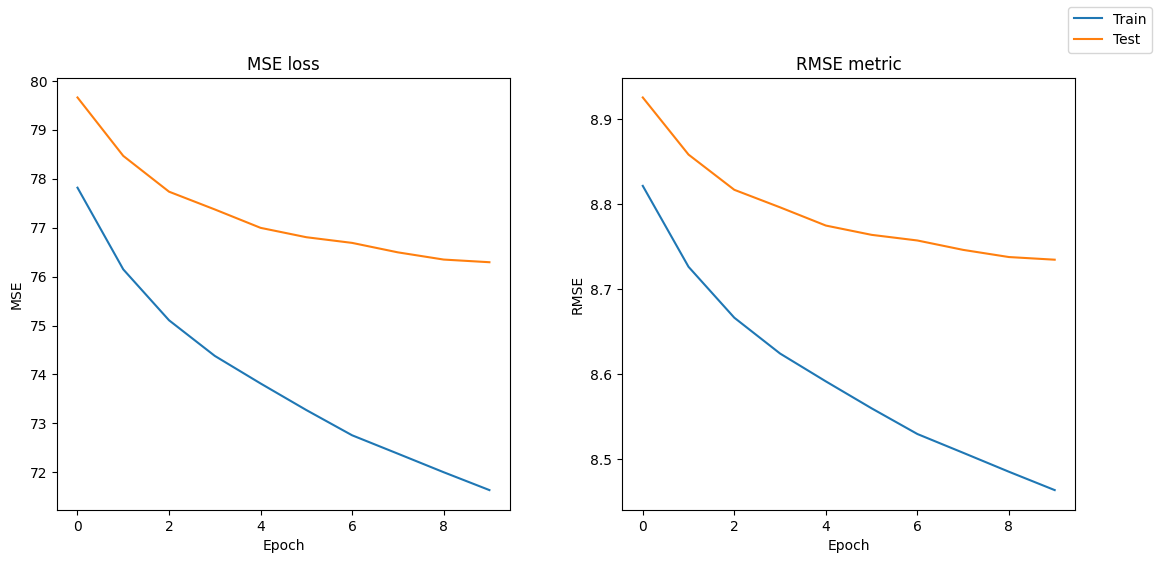

In [165]:
draw_charts(loss_on_train, metric_on_train, loss_on_test, metric_on_test)

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

### Этап 1. Отрицание и злость

Я решил попробовать повторить сетку с первого семинара и посмотреть, что выйдет. Также взял SGD с шагом 0.01 и 10 эпох.
```
model = nn.Sequential(
    nn.Linear(X_train_tensor.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)
```
Так как я уже сделал нормализацию, то была надежда на нормальную метрику. Но в итоге получилось `10.85` :(

Кроме этого, оказалось, что моя модель вообще не учится, потому что на графиках зависимости лоссов и метрик от эпохи представляли собой почти константу.

Попробовав добавить несколько новых слоев, поигравшись с гиперпараметрами и циклом обучения, я понял наверняка, что модель действительно не учится)

Оставалось только смотреть, что я не так делаю с данными. Немного упростил код обработки данных, избавился от лишних датафреймов и в итоге получил `RMSE 9.16`, при этом графики лосса и метрик практически совпадали друг с другом. Уже почти 4 балла, неплохо...

После этого я пробовал менять `learning_rate` у SDG, размер батчей и количество эпох, но это практически никак не влияло на метрику, поэтому пришлось думать дальше


### Этап 2. Торг с оптимизатором

На лекции нам успели рассказать про `Adam` и `Adagrad`.
Они дали мне `RMSE 8.93 и 8.83` соответственно.
Значит, дальше работаем c `Adagrad` с `lr=0.01`

После этого я попробовал перемешать данные (`shuffle=True` у даталоадера), потому что в теории это должно уменьшить переобучение и модель будет лучше выявлять закономерности. RMSE получилась поменьше, но графики лоссов и метрик на тесте стали ломаными. Стало грустно.

Видимо, модель и правда переобучается, и это надо исправлять.

### Этап 3. Архитектурная депрессия

Очевидно, надо добавлять `Dropout` и `BatchNorm1d`. Но перед этим надо увеличить количество линейных слоев, чтобы было куда их вставлять:

```
model = nn.Sequential(
    nn.Linear(X_train_tensor.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 192),
    nn.ReLU(),
    nn.Linear(192, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)
```

#### 3.1. Новые линейные слои
После добавления новых линейных слоев без перемешивания датасета метрика чуть улучшилась, получилось `8.81`. Но на графике стало видно, что на последних эпохах лосс и метрика на тесте начинают расти, а на тесте - стабильно падают. Возможно, получили еще одно доказательство переобучения

После перемешивания датасета получаем еще более ломаные графики на тесте. Получается, пора добавлять `Dropout` и `BatchNorm1d`.

#### 3.2. Dropout и BatchNorm1d

Сначала я добавил только `Dropout` с `p = 0.5` и получил `RMSE 8.9`. При этом с перемешанным датасетом графики на тесте стали более гладкие, что хороший знак.

После добавления `BatchNorm1d` получил `RMSE 8.86`. С перемешанным датасетом графики на тесте стали еще приятнее. То есть мы получили старый результат, но при этом наша модель гораздо лучше выявляет закономерности. Небольшая победа :)

#### 3.3. Играемся с параметрами

Возможно, дропаут выбрасывает слишком много информации. Нужно поиграться с вероятностью зануления элементов входного тензора и шагом градиентного спуска.

Получилось вот такое:
&nbsp;

| p = 0.4 | lr = 0.005 | lr = 0.01 | lr = 0.025 |
| --- | --- | --- | --- |
| RMSE | 8.87 | 8.81 | 8.77 | |
| Переобучение? | Норм | Не очень | Хорошо |

&nbsp;

| p = 0.3 | lr = 0.005 | lr = 0.01 | lr = 0.025 |
| --- | --- | --- | --- |
| RMSE | 8.83 | 8.79 | 8.75 | |
| Переобучение? | Не очень | Норм | Плохо |

&nbsp;

| p = 0.25 | lr = 0.005 | lr = 0.01 | lr = 0.025 |
| --- | --- | --- | --- |
| RMSE | 8.82 | 8.77 | 8.74 | |
| Переобучение? | Не очень | Норм | Не очень |

&nbsp;

(переобучение определялось по графику при перемешивании датасета)

Кажется, что оптимальные значения `p = 0.25 и lr = 0.01`. Но метрика немного не дотягивает до 8.75. Попробуем поменять нелинейную функцию

#### 3.4. Функция активации

Я попробовал поменял `ReLU` на `LeakyReLU`, потому что у нее в отрицательной зоне по идее должны лучше считаться градиенты. RMSE получился такой же `8.77`. Но при перемешивании датасета графики стали получше, поэтому, наверно, оставлю `LeakyReLU`

#### 3.5. Больше линейных слоев богу линейных слоев

Чтобы добить метрику, добавим несколько линейных слоев с дропаутами и батч нормализацией

```
model = nn.Sequential(
    nn.Linear(X_train_tensor.shape[1], 512),
    nn.BatchNorm1d(512),
    nn.LeakyReLU(),
    nn.Dropout(p=p),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.LeakyReLU(),
    nn.Dropout(p=p),
    nn.Linear(256, 192),
    nn.BatchNorm1d(192),
    nn.LeakyReLU(),
    nn.Dropout(p=p),
    nn.Linear(192, 128),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(),
    nn.Dropout(p=p),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.LeakyReLU(),
    nn.Dropout(p=p),
    nn.Linear(64, 32),
    nn.BatchNorm1d(32),
    nn.LeakyReLU(),
    nn.Linear(32, 1)
)
```
Получаем метрику `8.734`. При этом после перемешивания датасета графики получаются вполне стабильными.

Можно и дальше добавлять новые линейные слои, но я, наверно, остановлюсь на этом...

### Этап 4. Принятие мемов

![image](https://alexanderdyakonov.files.wordpress.com/2018/08/minimum.jpeg)